# Algorithm

In [ ]:
#Importing Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.patches as mpatches
import sys
import warnings
import os
from google.colab import files
import pickle
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [ ]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# converts midi files to wav files into order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('installing musescore...')
!apt install musescore3 > /dev/null

print('done!')

installing lilypond...
Extracting templates from packages: 100%
installing fluidsynth...
Extracting templates from packages: 100%
installing musescore...


done!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the list of chopin's midi files as stream
filepath = "/content/drive/MyDrive/ClassicalMusic/chopin/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi_ut = converter.parse(tr)
        k = midi_ut.analyze('key')
        i = interval.Interval(k.tonic, pitch.Pitch('C'))
        midi_nt = midi_ut.transpose(i)
        midi = midi_nt.stripTies()
        all_midis.append(midi)


In [ ]:
all_midis = all_midis[:5]

In [ ]:
def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(str(filename) + '.wav'))

def download(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  return (str(filename) + '.wav')

In [ ]:
def split_part(midis):
  all_midis_parts = []

  for midi in midis:
    for i in range(len(midi.parts)):
      all_midis_parts.append(midi.parts[i])

  return all_midis_parts

In [ ]:
all_midi_split = split_part(all_midis)

In [ ]:
len(all_midi_split)

11

In [ ]:
def split_clef(midis_parts):
  treble_clef_midi = []
  bass_clef_midi = []

  for midi in midis_parts:
    for element in midi.flat:

      clef_name = None

      if isinstance(element, music21.clef.Clef):
        clef_name = str(element.name)

        if clef_name  == 'treble':
          treble_clef_midi.append(midi)

        elif clef_name == 'bass':
          bass_clef_midi.append(midi)

  return treble_clef_midi, bass_clef_midi


In [ ]:
treble_midis, bass_midis = split_clef(all_midi_split)

In [ ]:
duplicates = [element for element in bass_midis if element in treble_midis]
print(duplicates)

[]


In [ ]:
def extract_notes_all(midi_clef):

  notes = []
  durations = []
  #types = []
  sequence_num = []

  for midi_part in midi_clef:
    for element in midi_part.flat:
      note_name = None
      duration_name  = None


    #if isinstance(element, music21.key.Key):
    # note_name = str(element.tonic.name) + ':' + str(element.mode)
    #  duration_name = "0.0"

    #elif isinstance(element, music21.meter.TimeSignature):
    #  note_name = str(element.ratioString) + 'TS'
    #  duration_name = "0.0"

      if isinstance(element, music21.chord.Chord):
        note_name = []
        duration_name = []
        for i in element.pitches:
          note_name.append(i.nameWithOctave)
        #note_name = element.pitches[-1].nameWithOctave
        #note_name = element
          #duration_name.append(element.duration.quarterLength)
        duration_name = float(element.duration.quarterLength)

      elif isinstance(element, music21.note.Rest):
        note_name = str(element.name)
        #note_name = element
        duration_name = float(element.duration.quarterLength)

      elif isinstance(element, music21.note.Note):
        note_name = str(element.nameWithOctave)
        #note_name = element
        duration_name = float(element.duration.quarterLength)

      if note_name and duration_name:
        notes.append(note_name)
        durations.append(duration_name)

  return notes, durations

In [ ]:
bass_midis_element = extract_notes_all(bass_midis)
treble_midis_element = extract_notes_all(treble_midis)

In [ ]:
len(bass_midis_element[0])

3963

In [ ]:
len(bass_midis_element[1])

3963

In [ ]:
len(treble_midis_element[0])

4435

In [ ]:
len(treble_midis_element[1])

4435

In [ ]:
bass_df = pd.DataFrame(bass_midis_element).T
bass_df.columns = ['music_element', 'duration']
bass_df

music_element duration
0               C2      0.5
1               B2      0.5
2               D3      0.5
3               C3      0.5
4               E3      0.5
...            ...      ...
3958            C1      2.0
3959            C2      4.0
3960          rest      1.0
3961            G1      3.0
3962            C1      2.0

[3963 rows x 2 columns]

In [ ]:
treble_df = pd.DataFrame(treble_midis_element).T
treble_df.columns = ['music_element', 'duration']
treble_df

music_element duration
0     [G3, C4, E4]      3.0
1     [C4, G3, E4]      3.0
2     [G3, E4, C4]      3.0
3             rest      3.0
4               B3      3.0
...            ...      ...
4430            C4     0.25
4431            C4      1.0
4432            C4     0.75
4433            C4     0.25
4434            C4      2.0

[4435 rows x 2 columns]

In [ ]:
chords_list_tr = []
for i in treble_df['music_element']:
  if type(i) == list:
    chords_list_tr.append(i)

In [ ]:
chords_list_bs = []
for i in bass_df['music_element']:
  if type(i) == list:
    chords_list_bs.append(i)

In [ ]:
unique_chords_tr = list(np.unique(np.array(chords_list_tr, dtype="object")))

In [ ]:
chords_dict_tr = dict()
for i in range(len((unique_chords_tr))):
  if type(unique_chords_tr[i]) == list:
    chords_dict_tr[str('CH') + str(i)] =unique_chords_tr[i]

In [ ]:
unique_chords_bs = list(np.unique(np.array(chords_list_bs, dtype="object")))

In [ ]:
chords_dict_bs = dict()
for i in range(len((unique_chords_bs))):
  if type(unique_chords_bs[i]) == list:
    chords_dict_bs[str('CH') + str(i)] =unique_chords_bs[i]

In [ ]:
unique_duration_tr = list(np.unique(np.array(treble_df['duration'])))

In [ ]:
duration_dict_tr = dict()
for i in range(len((unique_duration_tr))):
    duration_dict_tr[str('DR') + str(i)] =unique_duration_tr[i]

In [ ]:
unique_duration_bs = list(np.unique(np.array(bass_df['duration'])))

In [ ]:
duration_dict_bs = dict()
for i in range(len((unique_duration_bs))):
    duration_dict_bs[str('DR') + str(i)] =unique_duration_bs[i]

In [ ]:
for chord_str, chord_note_lst in chords_dict_tr.items():
  treble_df['music_element'] = treble_df['music_element'].apply(lambda x: chord_str if x == chord_note_lst else x)

for chord_str, chord_note_lst in chords_dict_bs.items():
  bass_df['music_element'] = bass_df['music_element'].apply(lambda x: chord_str if x == chord_note_lst else x)

In [ ]:
for duration_str, duration_lst in duration_dict_tr.items():
  treble_df['duration'] = treble_df['duration'].apply(lambda x: duration_str if x == duration_lst else x)

for duration_str, duration_lst in duration_dict_bs.items():
  bass_df['duration'] = bass_df['duration'].apply(lambda x: duration_str if x == duration_lst else x)

In [ ]:
label_encoder_chord_tr = preprocessing.LabelEncoder()

label_encoder_chord_tr.fit_transform(treble_df['music_element'])
treble_df['music_element']= label_encoder_chord_tr.transform(treble_df['music_element'])

label_encoder_chord_bs = preprocessing.LabelEncoder()

label_encoder_chord_bs.fit_transform(bass_df['music_element'])
bass_df['music_element']= label_encoder_chord_bs.transform(bass_df['music_element'])

In [ ]:
label_encoder_duration_tr = preprocessing.LabelEncoder()

label_encoder_duration_tr.fit_transform(treble_df['duration'])
treble_df['duration']= label_encoder_duration_tr.transform(treble_df['duration'])

label_encoder_duration_bs = preprocessing.LabelEncoder()

label_encoder_duration_bs.fit_transform(bass_df['duration'])
bass_df['duration']= label_encoder_duration_bs.transform(bass_df['duration'])

In [ ]:
train_notes_treble = treble_df.to_numpy()
train_notes_bass = bass_df.to_numpy()

In [ ]:
notes_ds_tr = tf.data.Dataset.from_tensor_slices(train_notes_treble)
notes_ds_bs = tf.data.Dataset.from_tensor_slices(train_notes_bass)

In [ ]:
key_order = ['music_element', 'duration']
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size_note = 0,
    vocab_size_duration = 0,
) -> tf.data.Dataset:

  seq_length = seq_length+1


  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)


  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)


  def scale_pitch(x):
    x = x/[vocab_size_note,vocab_size_duration]
    return x


  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
num_notes_tr = len(np.unique(list(treble_df['music_element'])))

In [ ]:
num_notes_bs = len(np.unique(list(bass_df['music_element'])))

In [ ]:
duration_tr = len(np.unique(list(treble_df['duration'])))

In [ ]:
duration_bs = len(np.unique(list(bass_df['duration'])))

In [ ]:
seq_length = 100

In [ ]:
vocab_size_note_tr = num_notes_tr
vocab_size_duration_tr = duration_tr
seq_ds_tr = create_sequences(notes_ds_tr, seq_length, vocab_size_note_tr, vocab_size_duration_tr)
seq_ds_tr.element_spec

(TensorSpec(shape=(100, 2), dtype=tf.float64, name=None),
 {'music_element': TensorSpec(shape=(), dtype=tf.int64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.int64, name=None)})

In [ ]:
vocab_size_note_bs = num_notes_bs
vocab_size_duration_bs = duration_bs
seq_ds_bs = create_sequences(notes_ds_bs, seq_length, vocab_size_note_bs, vocab_size_duration_bs)
seq_ds_bs.element_spec

(TensorSpec(shape=(100, 2), dtype=tf.float64, name=None),
 {'music_element': TensorSpec(shape=(), dtype=tf.int64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.int64, name=None)})

In [ ]:
batch_size = 64

In [ ]:
train_ds_tr = (seq_ds_tr
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds_bs = (seq_ds_bs
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
temp = 0.3

In [ ]:
filename = '/content/drive/MyDrive/ClassicalMusic/ModelChopin/MugenLSTM_tr.pkl'
lstm_tr = pickle.load(open(filename, 'rb'))

In [ ]:
filename = '/content/drive/MyDrive/ClassicalMusic/ModelChopin/MugenLSTM_bs.pkl'
lstm_bs = pickle.load(open(filename, 'rb'))

In [ ]:
def predict_next_note(notes, model: tf.keras.Model, num_notes = 0, num_duration = 0) -> tuple[int, float]:

  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  element = predictions['music_element']
  duration = predictions['duration']
  p_element, i_element = tf.math.top_k(element,k=10)
  p_duration, i_duration = tf.math.top_k(duration,k=5)

  p_element /= p_element.numpy().sum()

  i_element = tf.squeeze(i_element, axis=0)
  p_element = tf.squeeze(p_element, axis=0)
  p_element = p_element.numpy()


  p_duration /= p_duration.numpy().sum()

  i_duration = tf.squeeze(i_duration, axis=0)
  p_duration = tf.squeeze(p_duration, axis=0)
  p_duration = p_duration.numpy()

  p_element[-1] = 1 - np.sum(p_element[0:-1])

  element = np.random.choice(i_element, 1, p=p_element )

  p_duration[-1] = 1 - np.sum(p_duration[0:-1])
  duration = np.random.choice(i_duration, 1, p=p_duration )

  return element, duration

In [ ]:
def generate_note_df(num_prediction, start_point, input_notes_df, model, vocab_size_note, vocab_size_duration):

  sample_notes = np.stack([input_notes_df[key] for key in key_order], axis=1)
  input_notes = (sample_notes[start_point:seq_length+start_point] / np.array([vocab_size_note,vocab_size_duration]))
  models = model

  generated_notes = input_notes


  for i in range(num_prediction):
    element, duration = predict_next_note(input_notes, models, vocab_size_note,
                    vocab_size_duration)
    input_note = np.append(element, duration)
    generated_notes = np.append(generated_notes,np.expand_dims(input_note, 0)/np.array([vocab_size_note,vocab_size_duration]), axis = 0)
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0)/np.array([vocab_size_note,vocab_size_duration]), axis=0)

  generated_notes = pd.DataFrame(generated_notes, columns=(key_order))
  return generated_notes

# Music Generated (key: C - tempo: 90)

In [ ]:
start_ts = random.randint(0,len(treble_df)-100)
generated_note_tr = generate_note_df(100, start_ts, treble_df, lstm_tr, vocab_size_note_tr, vocab_size_duration_tr)

1/1 [==============================] - 0s 60ms/step


In [ ]:
treble_generated = generated_note_tr.to_numpy() * np.array([vocab_size_note_tr,vocab_size_duration_tr])

In [ ]:
treble_generated = treble_generated.astype('int64')

In [ ]:
treble_generated_df = pd.DataFrame(treble_generated, columns=(key_order))

In [ ]:
treble_generated_df = treble_generated_df.iloc[100:]

In [ ]:
treble_generated_df['music_element'] = label_encoder_chord_tr.inverse_transform(treble_generated_df['music_element'])
treble_generated_df['duration']= label_encoder_duration_tr.inverse_transform(treble_generated_df['duration'])

In [ ]:
for element_str, element_lst in chords_dict_tr.items():
  treble_generated_df['music_element'] = treble_generated_df['music_element'].apply(lambda x: element_lst if x == element_str else x)

for duration_str, duration_lst in duration_dict_tr.items():
  treble_generated_df['duration'] = treble_generated_df['duration'].apply(lambda x: duration_lst if x == duration_str else x)

In [ ]:
start_bs = random.randint(0,len(bass_df)-100)
generated_note_bs = generate_note_df(100, start_bs, bass_df, lstm_bs, vocab_size_note_bs, vocab_size_duration_bs)

1/1 [==============================] - 0s 62ms/step


In [ ]:
bass_generated = generated_note_bs.to_numpy() * np.array([vocab_size_note_bs,vocab_size_duration_bs])

In [ ]:
bass_generated = bass_generated.astype('int64')

In [ ]:
bass_generated_df = pd.DataFrame(bass_generated, columns=(key_order))

In [ ]:
bass_generated_df = bass_generated_df.iloc[100:]

In [ ]:
bass_generated_df['music_element'] = label_encoder_chord_bs.inverse_transform(bass_generated_df['music_element'])
bass_generated_df['duration']= label_encoder_duration_bs.inverse_transform(bass_generated_df['duration'])

In [ ]:
for element_str, element_lst in chords_dict_bs.items():
  bass_generated_df['music_element'] = bass_generated_df['music_element'].apply(lambda x: element_lst if x == element_str else x)

for duration_str, duration_lst in duration_dict_bs.items():
  bass_generated_df['duration'] = bass_generated_df['duration'].apply(lambda x: duration_lst if x == duration_str else x)

In [ ]:
main_stream = stream.Score(id='mainScore')
stream_part1 = stream.Part(id='Part1')
stream_part2 = stream.Part(id='Part2')
instrument1 = instrument.Piano()
clef1 = clef.TrebleClef()
clef2 = clef.BassClef()
tempos = tm2 = tempo.MetronomeMark(number=90)
keys = key.Key(pitch.Pitch('C'))
time_signature = meter.TimeSignature('4/4')

In [ ]:
def music_generation_part(stream_part, instrument, clef, tempo, key, time_signature, set_element):

  for i in [instrument, clef, tempo, key, time_signature]:
    stream_part.append(i)

  for notes, durations in zip(set_element[key_order[0]],set_element[key_order[1]]):
    note_name = None

    if type(notes) != list:

      if notes != 'rest':
        note_name = note.Note(notes)
        note_name.duration.quarterLength = durations
        stream_part.append(note_name)

      elif notes == 'rest':
        note_name = note.Rest()
        note_name.duration.quarterLength = durations
        stream_part.append(note_name)

    elif type(notes) == list:
      note_name = chord.Chord(notes)
      note_name.duration.quarterLength = durations
      stream_part.append(note_name)

  return stream_part

In [ ]:
treble_generation_part = music_generation_part(stream_part1, instrument1, clef1, tempos, keys, time_signature, treble_generated_df)

In [ ]:
bass_generation_part = music_generation_part(stream_part2, instrument1, clef2, tempos, keys, time_signature, bass_generated_df)

In [ ]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [ ]:
for i in bass_generation_part:
  if convert_to_float(i.offset) > convert_to_float(treble_generation_part[-1].offset):
    bass_generation_part.remove(i)

for i in treble_generation_part:
  if convert_to_float(i.offset) > convert_to_float(bass_generation_part[-1].offset):
    treble_generation_part.remove(i)

In [ ]:
def music_generation_main(main_score, stream_parts_list):
  for i in stream_parts_list:
    main_score.insert(0, i)

  return main_score

In [ ]:
music_generated_lstm_1 = music_generation_main(main_stream, [treble_generation_part, bass_generation_part])

In [ ]:
music_generated_lstm_1.show('text')

{0.0} <music21.stream.Part Part1>
    {0.0} <music21.instrument.Piano 'Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark maestoso Quarter=90>
    {0.0} <music21.key.Key of C major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note B>
    {0.25} <music21.note.Rest 16th>
    {0.5} <music21.note.Note B>
    {0.75} <music21.note.Note A>
    {1.0} <music21.note.Rest 1/6ql>
    {1.1667} <music21.note.Note B>
    {1.4167} <music21.note.Rest 16th>
    {1.6667} <music21.note.Note A>
    {1.9167} <music21.note.Rest 16th>
    {2.1667} <music21.note.Note D>
    {2.4167} <music21.note.Note G>
    {2.6667} <music21.note.Note C>
    {3.1667} <music21.note.Note C>
    {3.4167} <music21.note.Note C>
    {3.6667} <music21.note.Note A>
    {3.9167} <music21.note.Note C>
    {4.1667} <music21.note.Rest 16th>
    {4.4167} <music21.note.Note A>
    {4.6667} <music21.note.Note E->
    {4.9167} <music21.note.Note E>
    {5.1667} <music21.note.Note E->
  

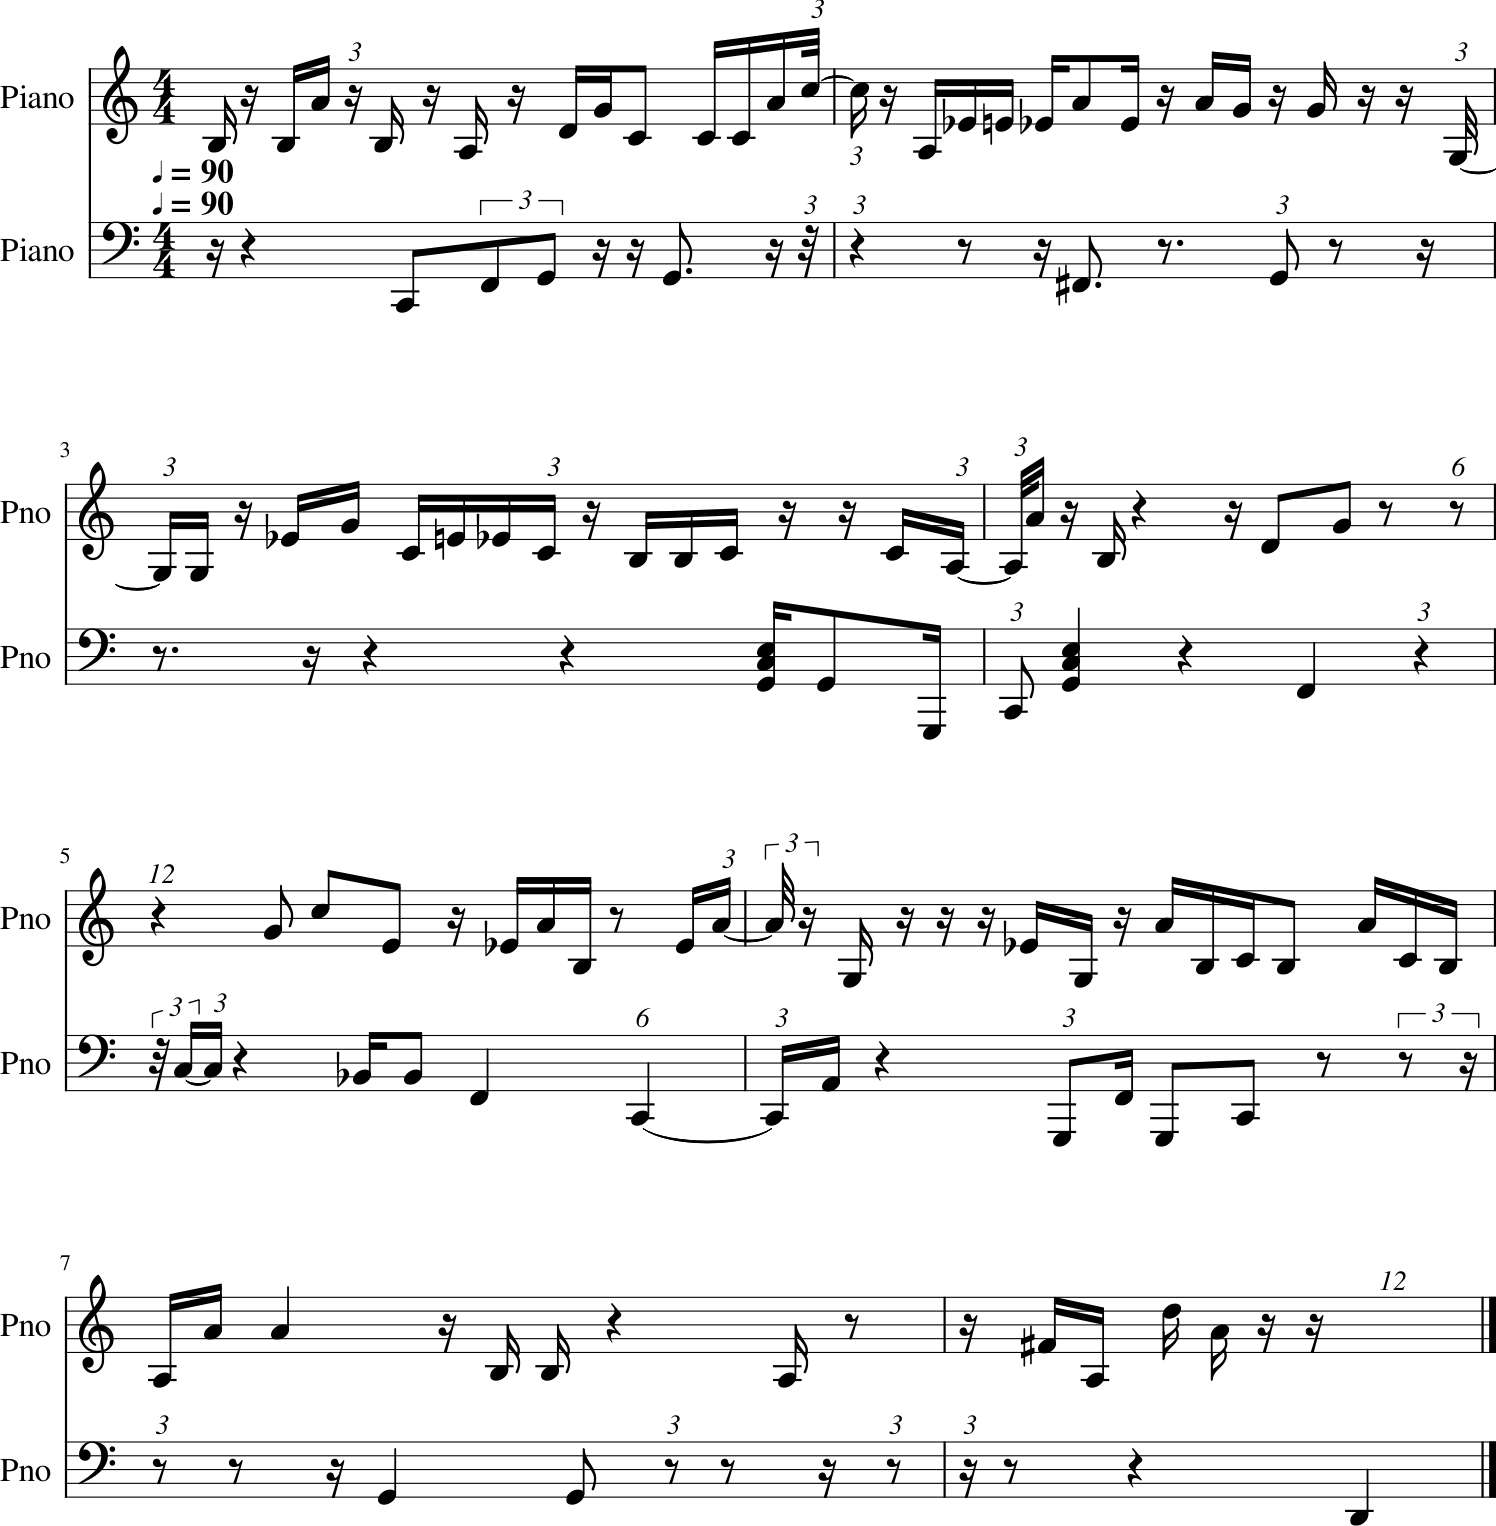

In [ ]:
music_generated_lstm_1.show()

In [ ]:
play(music_generated_lstm_1)

In [ ]:
files.download(download(music_generated_lstm_1))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Music Generated (key: A minor - tempo: 60)

In [ ]:
start_ts = random.randint(0,len(treble_df)-100)
generated_note_tr = generate_note_df(100, start_ts, treble_df, lstm_tr, vocab_size_note_tr, vocab_size_duration_tr)

1/1 [==============================] - 0s 82ms/step


In [ ]:
treble_generated = generated_note_tr.to_numpy() * np.array([vocab_size_note_tr,vocab_size_duration_tr])

In [ ]:
treble_generated = treble_generated.astype('int64')

In [ ]:
treble_generated_df = pd.DataFrame(treble_generated, columns=(key_order))

In [ ]:
treble_generated_df = treble_generated_df.iloc[100:]

In [ ]:
treble_generated_df['music_element'] = label_encoder_chord_tr.inverse_transform(treble_generated_df['music_element'])
treble_generated_df['duration']= label_encoder_duration_tr.inverse_transform(treble_generated_df['duration'])

In [ ]:
for element_str, element_lst in chords_dict_tr.items():
  treble_generated_df['music_element'] = treble_generated_df['music_element'].apply(lambda x: element_lst if x == element_str else x)

for duration_str, duration_lst in duration_dict_tr.items():
  treble_generated_df['duration'] = treble_generated_df['duration'].apply(lambda x: duration_lst if x == duration_str else x)

In [ ]:
start_bs = random.randint(0,len(bass_df)-100)
generated_note_bs = generate_note_df(100, start_bs, bass_df, lstm_bs, vocab_size_note_bs, vocab_size_duration_bs)

1/1 [==============================] - 0s 56ms/step


In [ ]:
bass_generated = generated_note_bs.to_numpy() * np.array([vocab_size_note_bs,vocab_size_duration_bs])

In [ ]:
bass_generated = bass_generated.astype('int64')

In [ ]:
bass_generated_df = pd.DataFrame(bass_generated, columns=(key_order))

In [ ]:
bass_generated_df = bass_generated_df.iloc[100:]

In [ ]:
bass_generated_df['music_element'] = label_encoder_chord_bs.inverse_transform(bass_generated_df['music_element'])
bass_generated_df['duration']= label_encoder_duration_bs.inverse_transform(bass_generated_df['duration'])

In [ ]:
for element_str, element_lst in chords_dict_bs.items():
  bass_generated_df['music_element'] = bass_generated_df['music_element'].apply(lambda x: element_lst if x == element_str else x)

for duration_str, duration_lst in duration_dict_bs.items():
  bass_generated_df['duration'] = bass_generated_df['duration'].apply(lambda x: duration_lst if x == duration_str else x)

In [ ]:
main_stream = stream.Score(id='mainScore')
stream_part1 = stream.Part(id='Part1')
stream_part2 = stream.Part(id='Part2')
instrument1 = instrument.Piano()
clef1 = clef.TrebleClef()
clef2 = clef.BassClef()
tempos = tm2 = tempo.MetronomeMark(number=60)
keys = key.Key(pitch.Pitch('a'))
time_signature = meter.TimeSignature('4/4')

In [ ]:
def music_generation_part(stream_part, instrument, clef, tempo, key, time_signature, set_element):

  for i in [instrument, clef, tempo, key, time_signature]:
    stream_part.append(i)

  for notes, durations in zip(set_element[key_order[0]],set_element[key_order[1]]):
    note_name = None

    if type(notes) != list:

      if notes != 'rest':
        note_name = note.Note(notes)
        note_name.duration.quarterLength = durations
        stream_part.append(note_name)

      elif notes == 'rest':
        note_name = note.Rest()
        note_name.duration.quarterLength = durations
        stream_part.append(note_name)

    elif type(notes) == list:
      note_name = chord.Chord(notes)
      note_name.duration.quarterLength = durations
      stream_part.append(note_name)

  return stream_part

In [ ]:
treble_generation_part = music_generation_part(stream_part1, instrument1, clef1, tempos, keys, time_signature, treble_generated_df)

In [ ]:
bass_generation_part = music_generation_part(stream_part2, instrument1, clef2, tempos, keys, time_signature, bass_generated_df)

In [ ]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [ ]:
for i in bass_generation_part:
  if convert_to_float(i.offset) > convert_to_float(treble_generation_part[-1].offset):
    bass_generation_part.remove(i)

for i in treble_generation_part:
  if convert_to_float(i.offset) > convert_to_float(bass_generation_part[-1].offset):
    treble_generation_part.remove(i)

In [ ]:
def music_generation_main(main_score, stream_parts_list):
  for i in stream_parts_list:
    main_score.insert(0, i)

  return main_score

In [ ]:
music_generated_lstm_2 = music_generation_main(main_stream, [treble_generation_part, bass_generation_part])

In [ ]:
music_generated_lstm_2.show('text')

{0.0} <music21.stream.Part Part1>
    {0.0} <music21.instrument.Piano 'Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark larghetto Quarter=60>
    {0.0} <music21.key.Key of A major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 16th>
    {0.25} <music21.note.Rest 16th>
    {0.5} <music21.note.Rest 16th>
    {0.75} <music21.note.Rest 16th>
    {1.0} <music21.note.Rest 16th>
    {1.25} <music21.note.Note B>
    {1.5} <music21.note.Note E->
    {1.75} <music21.note.Note C>
    {2.0} <music21.note.Note E>
    {2.25} <music21.note.Note D>
    {2.5} <music21.note.Note B>
    {2.75} <music21.note.Note D>
    {3.75} <music21.note.Rest 16th>
    {4.0} <music21.note.Rest 16th>
    {4.25} <music21.note.Rest 16th>
    {4.5} <music21.note.Note A>
    {4.75} <music21.note.Note G>
    {5.0} <music21.note.Note E>
    {5.25} <music21.note.Note C>
    {5.5} <music21.note.Note G>
    {6.5} <music21.note.Note B>
    {7.0} <music21.note.Note B>
  

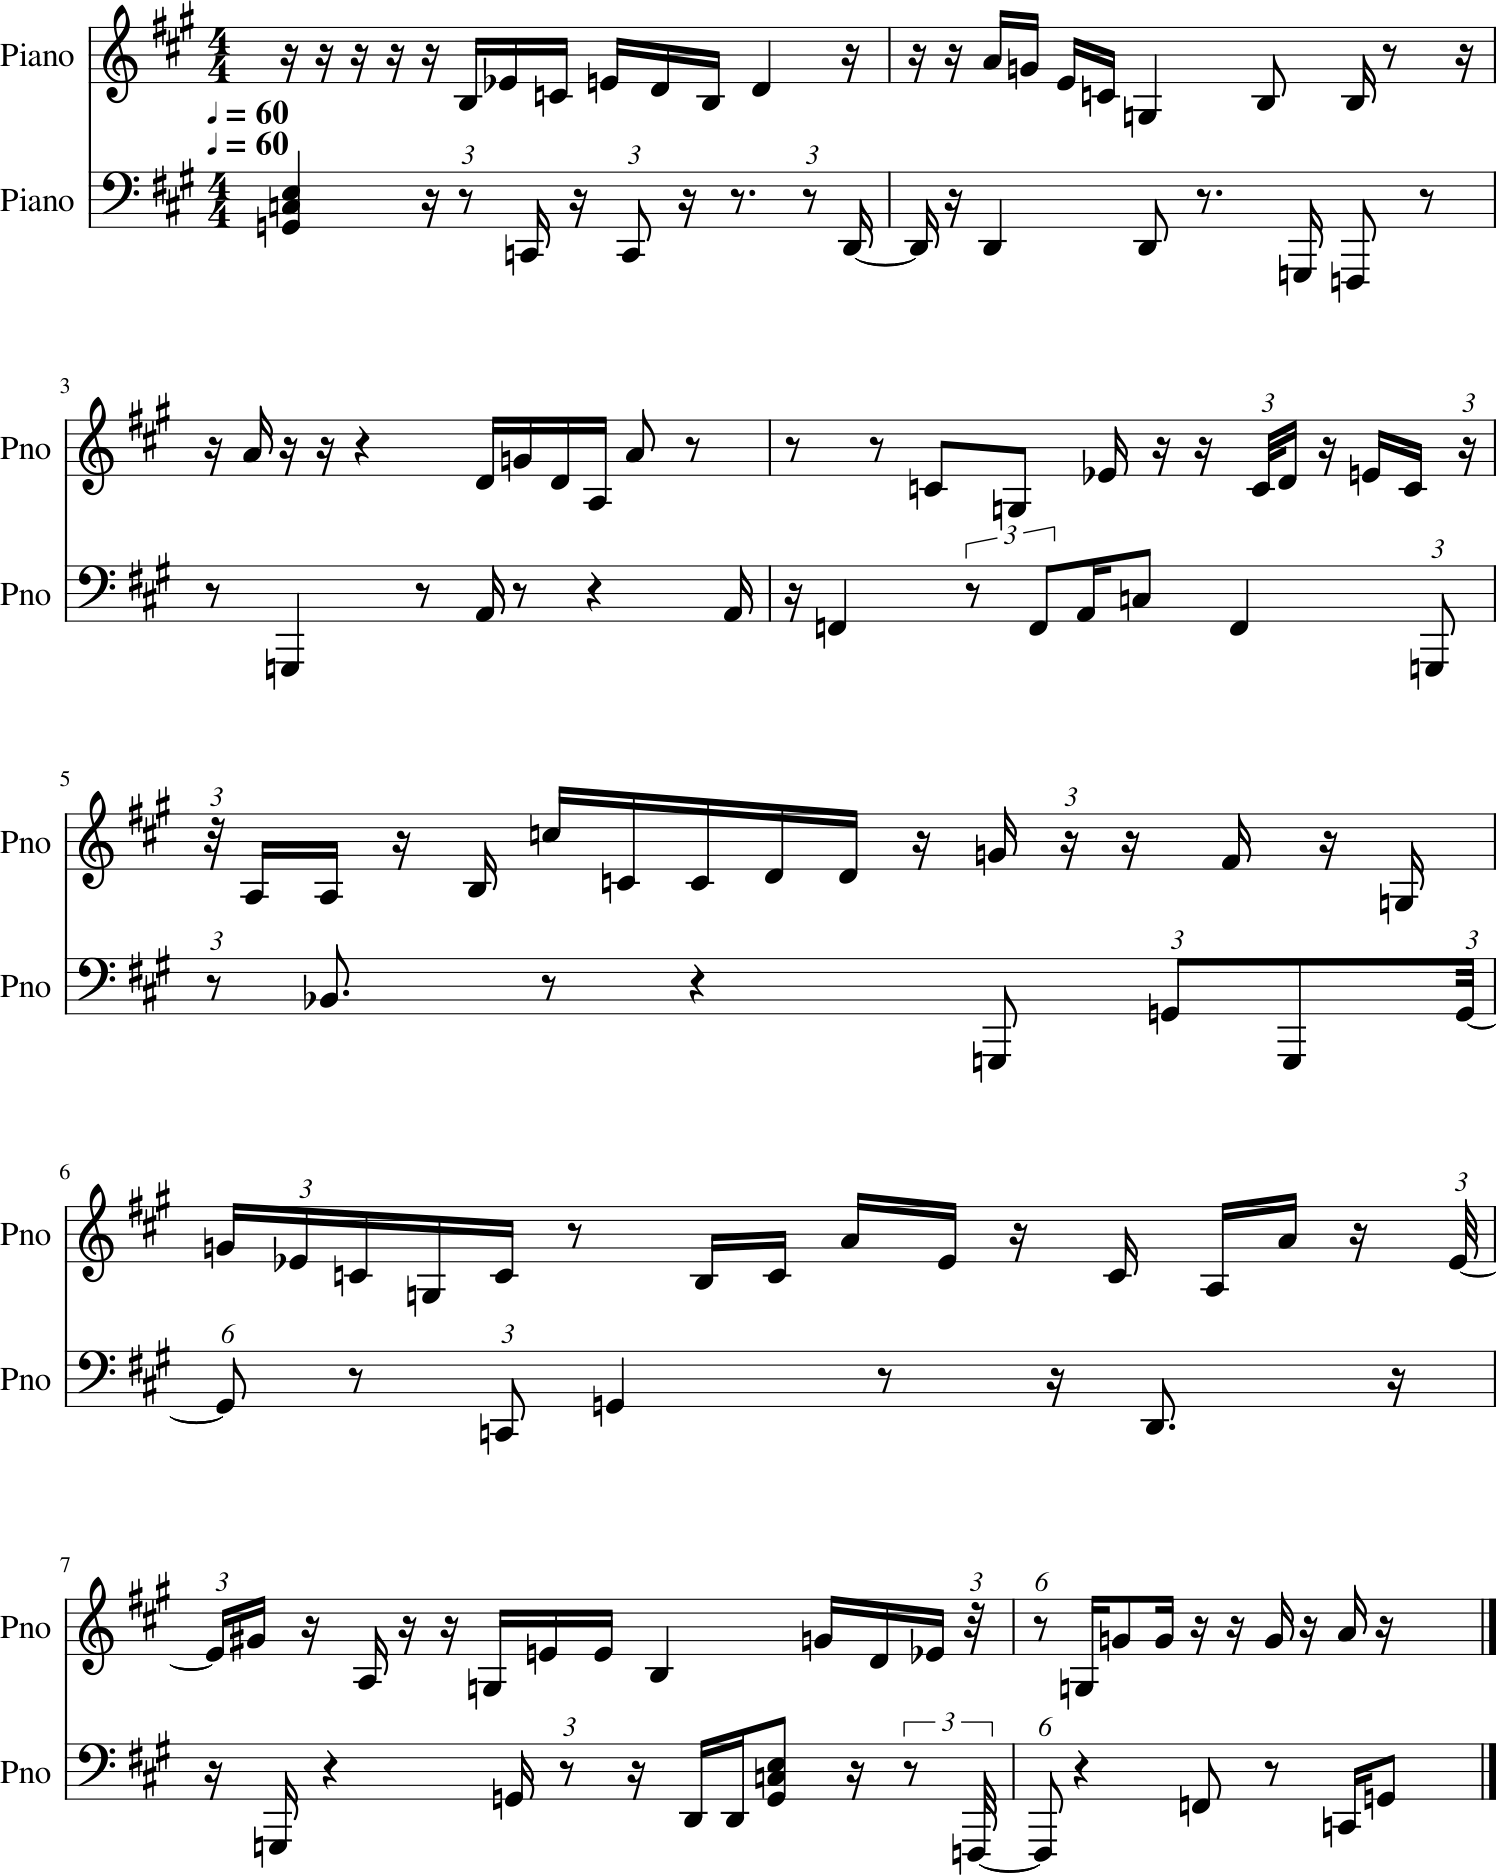

In [ ]:
music_generated_lstm_2.show()

In [ ]:
play(music_generated_lstm_2)

In [ ]:
files.download(download(music_generated_lstm_2))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Music Generated (key: E minor - tempo: 120)

In [ ]:
start_ts = random.randint(0,len(treble_df)-100)
generated_note_tr = generate_note_df(100, start_ts, treble_df, lstm_tr, vocab_size_note_tr, vocab_size_duration_tr)

1/1 [==============================] - 0s 243ms/step


In [ ]:
treble_generated = generated_note_tr.to_numpy() * np.array([vocab_size_note_tr,vocab_size_duration_tr])

In [ ]:
treble_generated = treble_generated.astype('int64')

In [ ]:
treble_generated_df = pd.DataFrame(treble_generated, columns=(key_order))

In [ ]:
treble_generated_df = treble_generated_df.iloc[100:]

In [ ]:
treble_generated_df['music_element'] = label_encoder_chord_tr.inverse_transform(treble_generated_df['music_element'])
treble_generated_df['duration']= label_encoder_duration_tr.inverse_transform(treble_generated_df['duration'])

In [ ]:
for element_str, element_lst in chords_dict_tr.items():
  treble_generated_df['music_element'] = treble_generated_df['music_element'].apply(lambda x: element_lst if x == element_str else x)

for duration_str, duration_lst in duration_dict_tr.items():
  treble_generated_df['duration'] = treble_generated_df['duration'].apply(lambda x: duration_lst if x == duration_str else x)

In [ ]:
start_bs = random.randint(0,len(bass_df)-100)
generated_note_bs = generate_note_df(100, start_bs, bass_df, lstm_bs, vocab_size_note_bs, vocab_size_duration_bs)

1/1 [==============================] - 0s 54ms/step


In [ ]:
bass_generated = generated_note_bs.to_numpy() * np.array([vocab_size_note_bs,vocab_size_duration_bs])

In [ ]:
bass_generated = bass_generated.astype('int64')

In [ ]:
bass_generated_df = pd.DataFrame(bass_generated, columns=(key_order))

In [ ]:
bass_generated_df = bass_generated_df.iloc[100:]

In [ ]:
bass_generated_df['music_element'] = label_encoder_chord_bs.inverse_transform(bass_generated_df['music_element'])
bass_generated_df['duration']= label_encoder_duration_bs.inverse_transform(bass_generated_df['duration'])

In [ ]:
for element_str, element_lst in chords_dict_bs.items():
  bass_generated_df['music_element'] = bass_generated_df['music_element'].apply(lambda x: element_lst if x == element_str else x)

for duration_str, duration_lst in duration_dict_bs.items():
  bass_generated_df['duration'] = bass_generated_df['duration'].apply(lambda x: duration_lst if x == duration_str else x)

In [ ]:
main_stream = stream.Score(id='mainScore')
stream_part1 = stream.Part(id='Part1')
stream_part2 = stream.Part(id='Part2')
instrument1 = instrument.Piano()
clef1 = clef.TrebleClef()
clef2 = clef.BassClef()
tempos = tm2 = tempo.MetronomeMark(number=120)
keys = key.Key(pitch.Pitch('e'))
time_signature = meter.TimeSignature('4/4')

In [ ]:
def music_generation_part(stream_part, instrument, clef, tempo, key, time_signature, set_element):

  for i in [instrument, clef, tempo, key, time_signature]:
    stream_part.append(i)

  for notes, durations in zip(set_element[key_order[0]],set_element[key_order[1]]):
    note_name = None

    if type(notes) != list:

      if notes != 'rest':
        note_name = note.Note(notes)
        note_name.duration.quarterLength = durations
        stream_part.append(note_name)

      elif notes == 'rest':
        note_name = note.Rest()
        note_name.duration.quarterLength = durations
        stream_part.append(note_name)

    elif type(notes) == list:
      note_name = chord.Chord(notes)
      note_name.duration.quarterLength = durations
      stream_part.append(note_name)

  return stream_part

In [ ]:
treble_generation_part = music_generation_part(stream_part1, instrument1, clef1, tempos, keys, time_signature, treble_generated_df)

In [ ]:
bass_generation_part = music_generation_part(stream_part2, instrument1, clef2, tempos, keys, time_signature, bass_generated_df)

In [ ]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [ ]:
for i in bass_generation_part:
  if convert_to_float(i.offset) > convert_to_float(treble_generation_part[-1].offset):
    bass_generation_part.remove(i)

for i in treble_generation_part:
  if convert_to_float(i.offset) > convert_to_float(bass_generation_part[-1].offset):
    treble_generation_part.remove(i)

In [ ]:
def music_generation_main(main_score, stream_parts_list):
  for i in stream_parts_list:
    main_score.insert(0, i)

  return main_score

In [ ]:
music_generated_lstm_3 = music_generation_main(main_stream, [treble_generation_part, bass_generation_part])

In [ ]:
music_generated_lstm_3.show('text')

{0.0} <music21.stream.Part Part1>
    {0.0} <music21.instrument.Piano 'Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark animato Quarter=120>
    {0.0} <music21.key.Key of E major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 16th>
    {0.25} <music21.note.Note C>
    {0.5} <music21.note.Rest 16th>
    {0.75} <music21.note.Note G>
    {1.0} <music21.note.Rest 16th>
    {1.25} <music21.note.Rest 16th>
    {1.5} <music21.note.Note A>
    {1.75} <music21.note.Note C>
    {2.0} <music21.note.Note C>
    {2.5} <music21.note.Rest 16th>
    {2.75} <music21.note.Note C>
    {3.0} <music21.note.Note G>
    {3.25} <music21.note.Note C>
    {3.5} <music21.note.Note A>
    {5.0} <music21.note.Rest 16th>
    {5.25} <music21.note.Rest 16th>
    {5.5} <music21.note.Note A>
    {5.5833} <music21.note.Note A>
    {5.8333} <music21.note.Rest 16th>
    {6.0833} <music21.note.Rest 16th>
    {6.3333} <music21.note.Note E->
    {6.5833} <music21.n

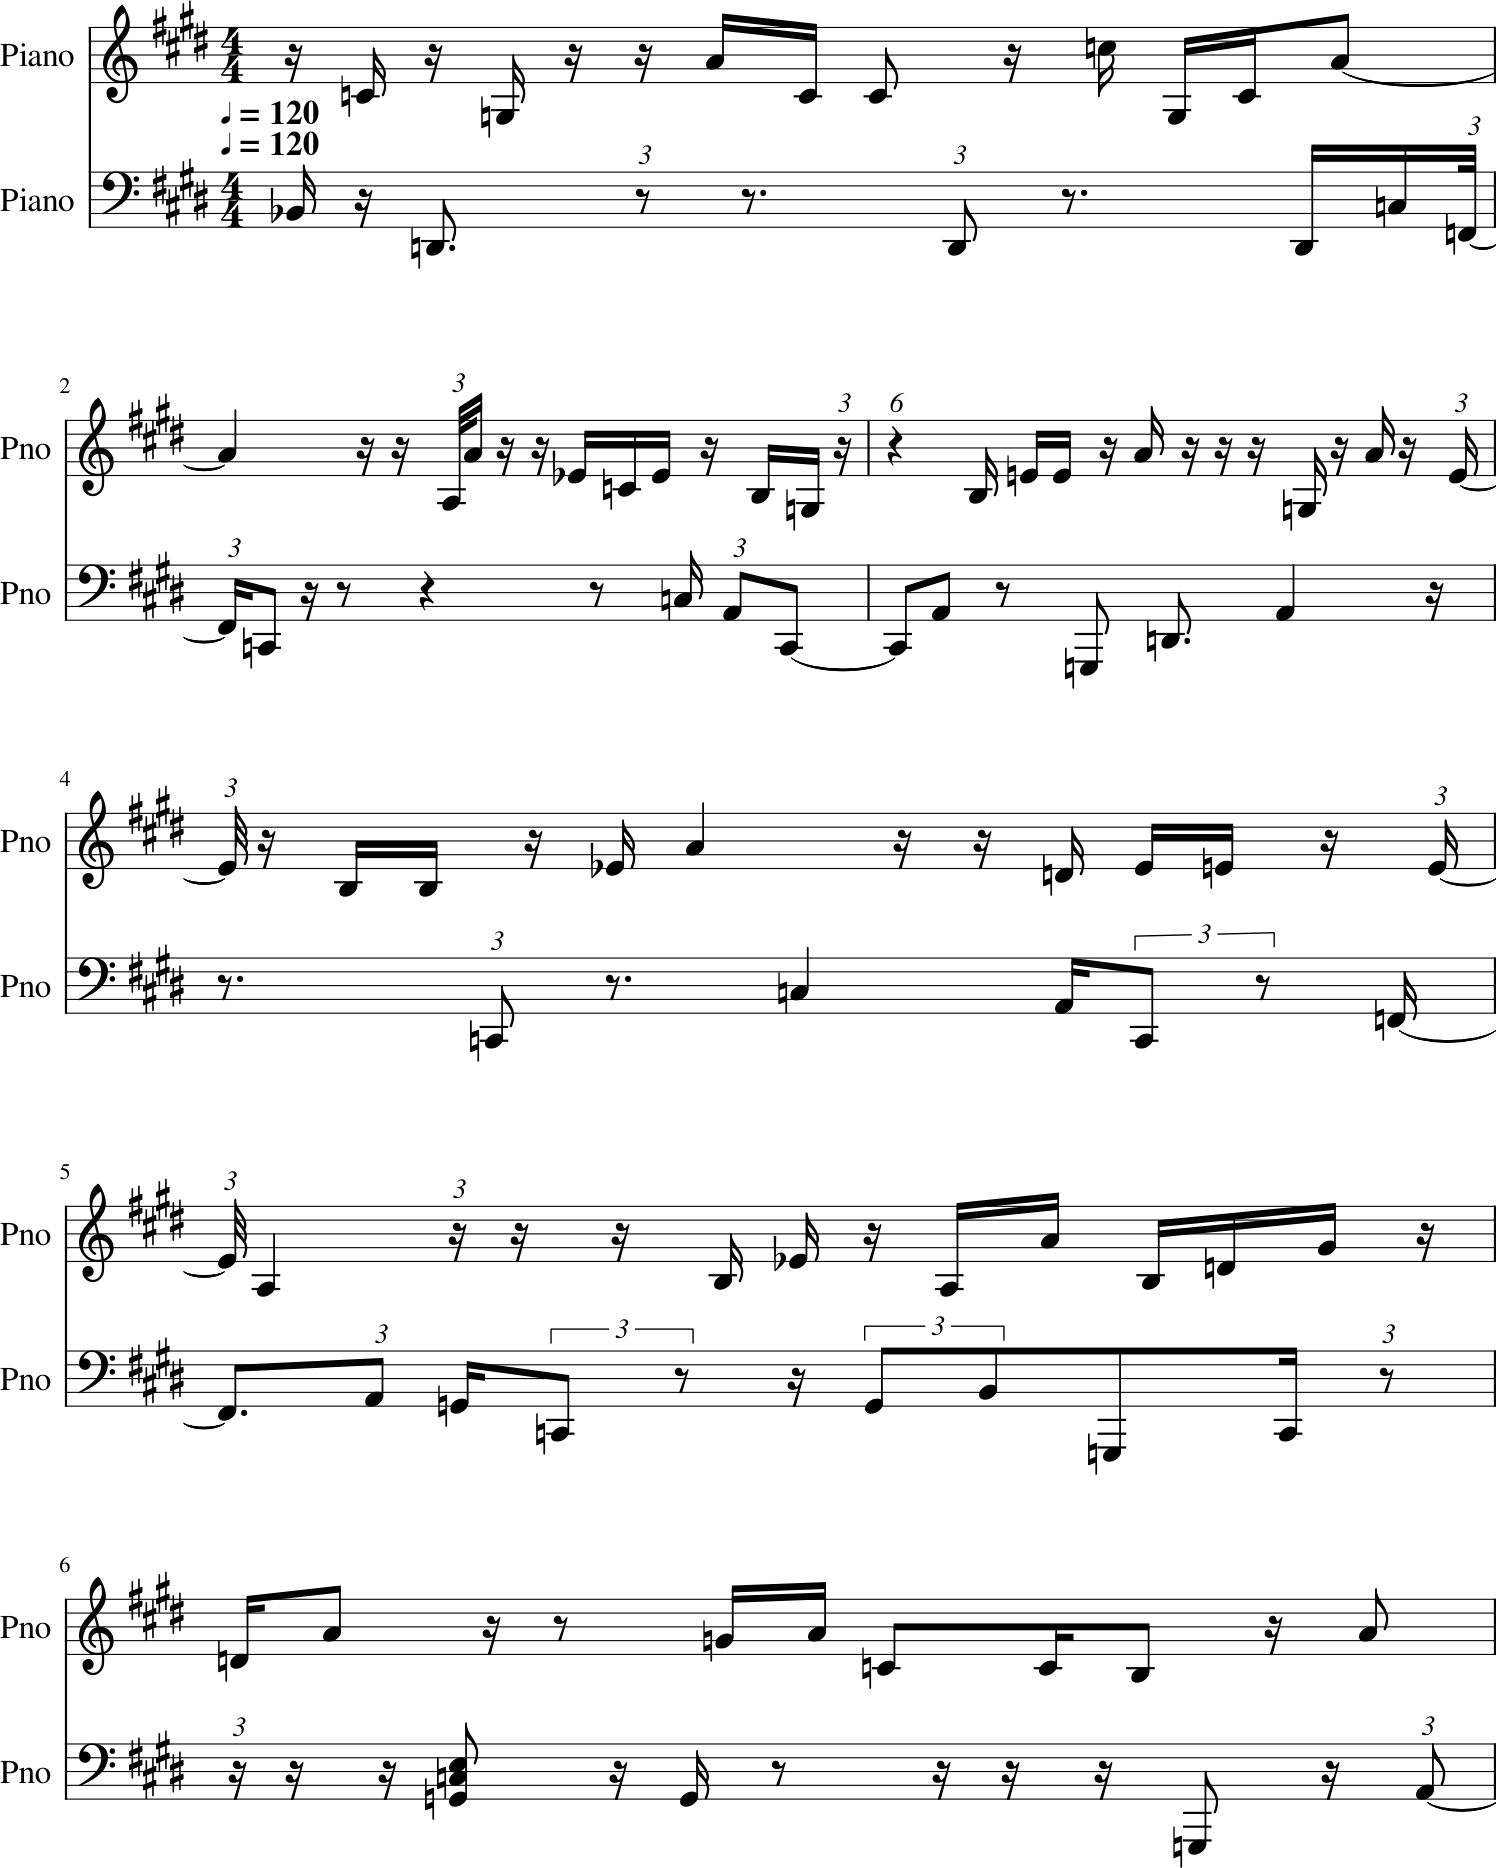

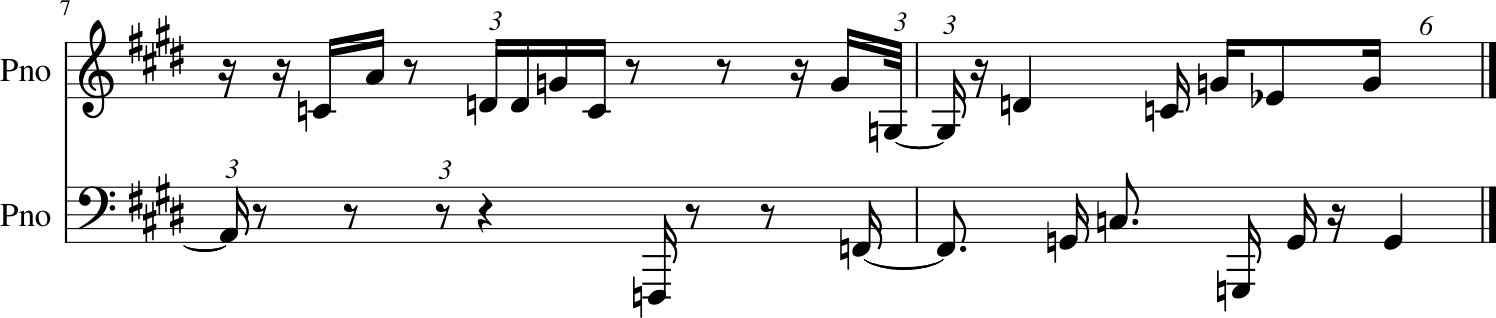

In [ ]:
music_generated_lstm_3.show()

In [ ]:
play(music_generated_lstm_3)

In [ ]:
files.download(download(music_generated_lstm_3))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>